# HITL : Static interrupts 

https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/

* Checkpointer is needed for interrupts
* Static interrupts may be specified at compile time

https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.state.StateGraph

* To resume the graph use : **invoke(Command(resume = value, goto= ...)

### Static interrupts
https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.state.StateGraph.compile

### interrupt
https://langchain-ai.github.io/langgraph/reference/types/#langgraph.types.interrupt

### Command
https://langchain-ai.github.io/langgraph/reference/types/#langgraph.types.Command

In [1]:
from typing import TypedDict, List
from langgraph.types import Command
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import InMemorySaver
from IPython.display import Image, display

# Provide the schema in the form of keys & their types
class StateHITL(TypedDict):
    test_str: str  # Each node appends its identity to this string
    
# Node A
def node_a(state: StateHITL)->dict:
    print("Node A : ", state["test_str"])
    return {"test_str": state["test_str"] + " :A "}

# Node B
def node_b(state: StateHITL)->dict:
    print("Node B : ", state["test_str"])
    return {"test_str": state["test_str"] + " :B "}

# Node C
def node_c(state: StateHITL)->dict:
    print("Node C : ", state["test_str"])
    return {"test_str": state["test_str"] + " :C "}

# Create a stateful graph
workflow_hitl = StateGraph(StateHITL)

# Add the nodes
workflow_hitl.add_node("node_a", node_a)
workflow_hitl.add_node("node_b", node_b)
workflow_hitl.add_node("node_c", node_c)

# Add the edges
workflow_hitl.add_edge(START, "node_a")  
workflow_hitl.add_edge("node_a", "node_b")
workflow_hitl.add_edge("node_b", "node_c")
workflow_hitl.add_edge("node_c", END)



## No interrupts

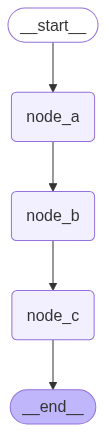

In [2]:
# Prepares the graph from the node/edge relations
checkpointer = InMemorySaver()
workflow_hitl_compiled = workflow_hitl.compile(checkpointer=checkpointer)

# Visualize the graph
display(Image(workflow_hitl_compiled.get_graph().draw_mermaid_png()))

## Interrupt before/after B

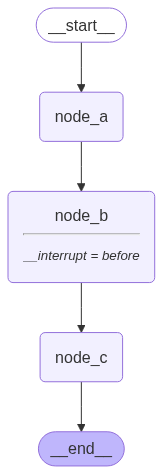

In [6]:
# Prepares the graph from the node/edge relations
checkpointer = InMemorySaver()

# Before
workflow_hitl_compiled = workflow_hitl.compile(checkpointer=checkpointer, interrupt_before=["node_b"])

# After
# workflow_hitl_compiled = workflow_hitl.compile(checkpointer=checkpointer, interrupt_after=["node_b"])

# Visualize the graph
display(Image(workflow_hitl_compiled.get_graph().draw_mermaid_png()))

## Test graph

* Make changes to previous cell for before/after interrupt
* Run the cells below to check out the next node
* Resume graph by invoking again with input = None

In [7]:
# Setup the thread_id
config = {"configurable": {"thread_id": 2}}

response = workflow_hitl_compiled.invoke({"test_str": "its a sunny day"}, config=config)

# Get the state of the graph and extract next node to be executed
next_node = workflow_hitl_compiled.get_state(config=config).next
print("Next node to be executed : ", next_node)

Node A :  its a sunny day
Next node to be executed :  ('node_b',)


In [8]:
# Resume the graph from last interrupt point by providing None instead of Command
response  = workflow_hitl_compiled.invoke(None, config=config)

# response
print("Final reponse: ", response)

Node B :  its a sunny day :A 
Node C :  its a sunny day :A  :B 
Final reponse:  {'test_str': 'its a sunny day :A  :B  :C '}
